In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# load the dataset
transcript_df = pd.read_csv("transcript.csv")
print(transcript_df.head())

   start                                               text
0    0.0  As you can see from this diagram, the process ...
1    4.4  Let me show you a different perspective on thi...
2    8.0  Now we'll explore how this integrates with the...
3   15.3     This function takes three parameters as input.
4   17.8  The scalability of this solution is crucial fo...


In [2]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   600 non-null    float64
 1   text    600 non-null    object 
dtypes: float64(1), object(1)
memory usage: 9.5+ KB
None

Basic Statistics:
             start
count   600.000000
mean   1397.931833
std     815.052624
min       0.000000
25%     697.950000
50%    1380.750000
75%    2098.700000
max    2845.400000


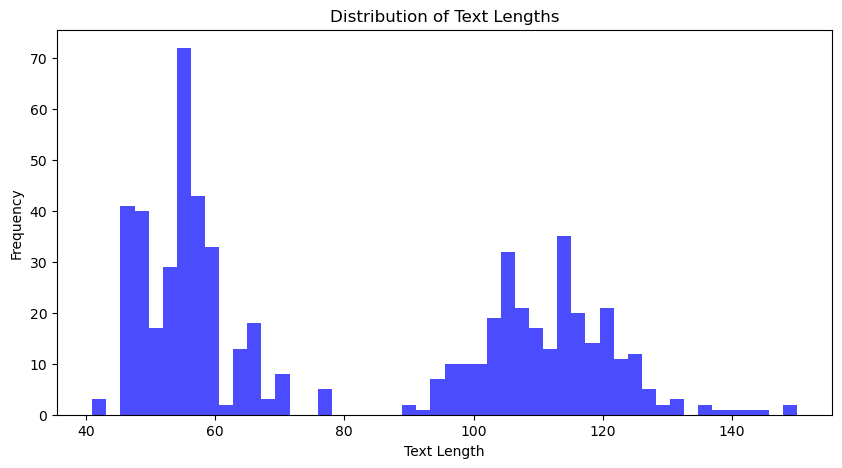

In [3]:
# distribution of text lengths
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

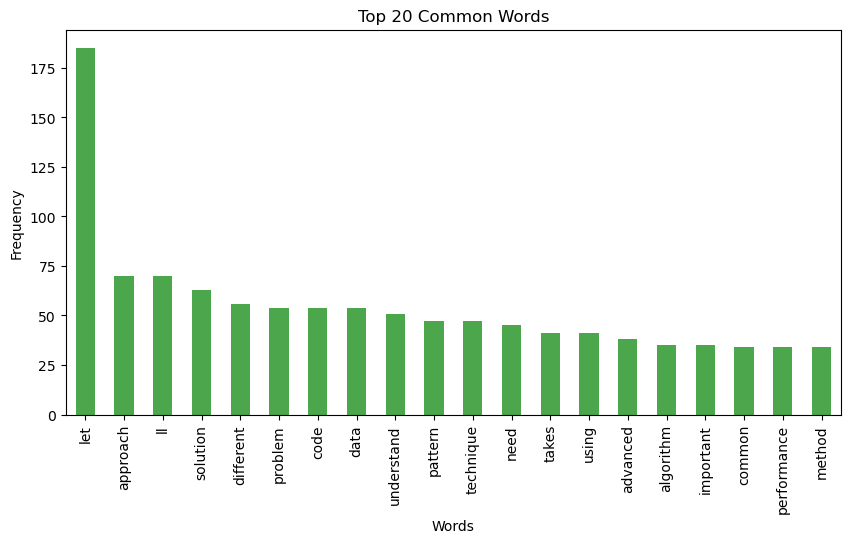

In [4]:
# most common words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [5]:
# topic Modeling using NMF
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: let step code walk implementation break simpler components sample test
Topic 2: ll pattern common code production important learn concepts documentation look
Topic 3: understand underlying need insight key principles visualization helps patterns make
Topic 4: approach edge careful requires consideration cases method offs discuss trade
Topic 5: advanced explore today machine learning going techniques topics foundation integrates
Topic 6: performance improvement technique using clear results metrics significant following output
Topic 7: solution critical parts highlight subproblems involves breaking datasets crucial large
Topic 8: different problem perspective apply problems principle let computer science classic
Topic 9: data structure patterns provides efficient access flows pipeline implementation sample
Topic 10: takes function input parameters actual place computation method effective proven


In [6]:
# get topic distribution for each text segment
topic_distribution = nmf.transform(tf)

# align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [7]:
# analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [8]:
# consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [9]:
# merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # append the last chapter

In [10]:
# Convert the final chapters to a readable time format
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:08 - Chapter 1: different let problem
00:01:09 - Chapter 2: common ll pattern
00:02:14 - Chapter 3: improvement performance technique
00:03:16 - Chapter 4: data flows structure
00:04:18 - Chapter 5: common ll pattern
00:05:25 - Chapter 6: need underlying understand
00:06:26 - Chapter 7: let simpler step
00:07:31 - Chapter 8: improvement performance technique
00:08:33 - Chapter 9: let simpler step
00:09:38 - Chapter 10: common ll pattern
00:10:40 - Chapter 11: approach let method
00:11:43 - Chapter 12: common ll pattern
00:12:45 - Chapter 13: need underlying understand
00:13:48 - Chapter 14: approach let method
00:14:49 - Chapter 15: make underlying understand
00:15:49 - Chapter 16: improvement performance technique
00:16:54 - Chapter 17: components let step
00:17:55 - Chapter 18: improvement performance technique
00:18:58 - Chapter 19: data pipeline structure
00:19:59 - Chapter 20: advanced machine techniques
00:21:00 - Chapter 21: different let 